In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

# Data Load & Check

In [2]:
train_df = pd.read_csv("./Data/train.csv")
test_df = pd.read_csv("./Data/test.csv")

test_id = test_df["PassengerId"]

### Outlier Detection

In [6]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

In [7]:
# numerical data 에 대해서 아웃라이어를 찾는다.

Outliers_to_drop = detect_outliers(train_df, 2, ["Age", "SibSp", "Parch", "Fare"])

In [9]:
train_df.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [11]:
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

### Joining Train and Test set

train set 과 test set에 같은 데이터 처리 작업을 수행해주기 위해 두 데이터를 합쳐서 다루도록 하겠다.

In [12]:
train_len = len(train_df)
df = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)

In [ ]:
df = df.fillna(np.nan)

df.isnull().sum()
# survived 에 있는 null 값 418개는 test 셋에 라벨이 없는 것이므로 신경쓰지 않아도 된다.

Age and Cabin features have an important part of missing values.

In [18]:
train_df.info()

train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [19]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

### Numerical Values

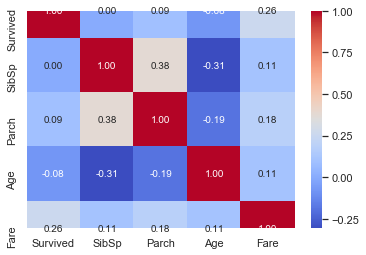

In [20]:
g = sns.heatmap(train_df[["Survived", "SibSp", "Parch",
                         "Age", "Fare"]].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

Only Fare feature seems to have a significative correlation with the survival probability.

It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.

###### SibSp

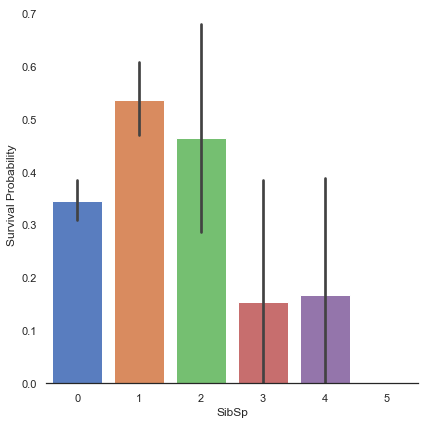

In [24]:
g = sns.factorplot(x = "SibSp", y = "Survived", data = train_df , kind = "bar",
                  size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Survival Probability")

###### Parch

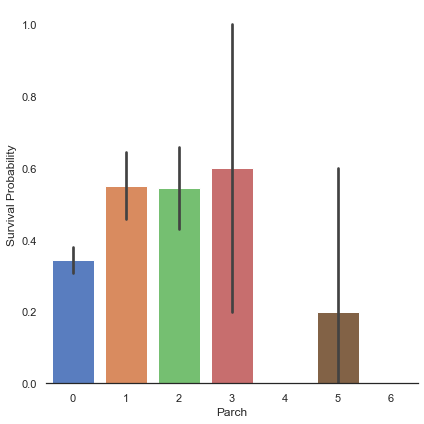

In [25]:
g = sns.factorplot(x = "Parch", y = "Survived", data = train_df, kind = "bar",
                  size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Survival Probability")

###### Age

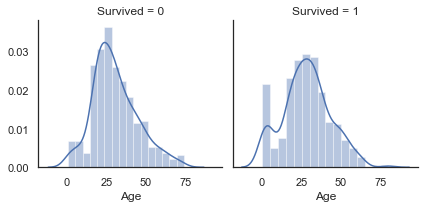

In [28]:
# 연속형 수치 데이터
g = sns.FacetGrid(train_df, col = "Survived")
g = g.map(sns.distplot, "Age")

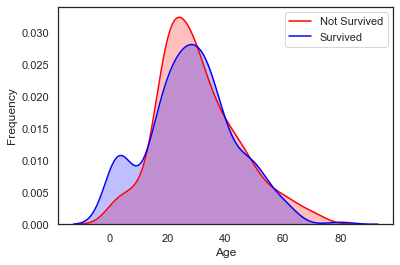

In [29]:
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 0) & (train_df["Age"].notnull())], color = "Red", shade = True)
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 1) & (train_df["Age"].notnull())], ax = g, color = "Blue", shade = True)

g.set_xlabel("Age")
g.set_ylabel("Frequency")

g = g.legend(["Not Survived", "Survived"])

###### Fare

In [30]:
df["Fare"].isnull().sum()

1

(array([ 20., 472., 198.,  69.,  69., 148.,  42.,  28.,   8.,  17.,  32.,
         26.,  11.,  10.,  16.,  24.,  15.,   9.,   4.,   0.,   3.,   7.,
          3.,   4.,   0.,   0.,  13.,   0.,   3.,   9.,   0.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,   4.,
          5.,   0.,   0.,   0.,   3.,   0.,   0.,  10.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.]),
 array([  0.      ,   5.123292,  10.246584,  15.369876,  20.493168,
         25.61646 ,  30.739752,  35.863044,  40.986336,  46.109628,
         51.23292 ,  56.356212,  61.479504,  66.602796,  71.726088,
         76.84938 ,  81.972672,  87.095964,  92.219256,  97.342548,
        102.46584 , 107.589132, 112.712424, 11

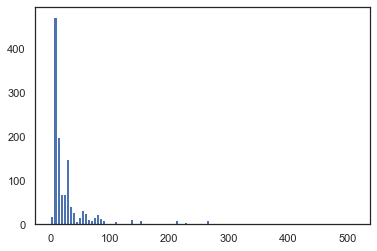

In [38]:
plt.hist(df["Fare"], bins = 100)

In [37]:
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

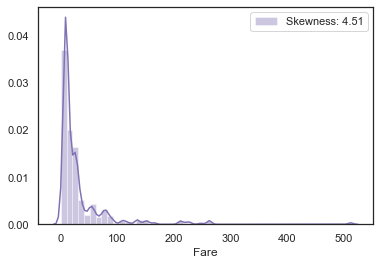

In [39]:
g = sns.distplot(df["Fare"], color = "m", label = "Skewness: %.2f"%(df["Fare"].skew()))
g = g.legend(loc = "best")

As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.
(로그 스케일로 변환)

In [40]:
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

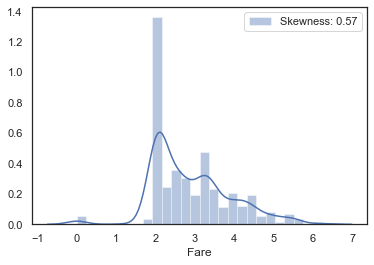

In [41]:
g = sns.distplot(df["Fare"], color = "b", label = "Skewness: %.2f"%(df["Fare"].skew()))
g = g.legend(loc = "best")

### Categorical Values

###### Sex

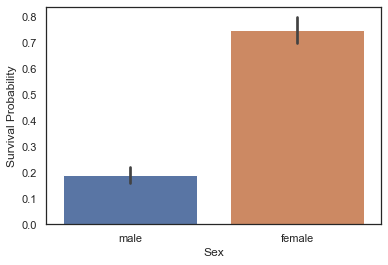

In [43]:
g = sns.barplot(x = "Sex", y = "Survived", data = train_df)
g = g.set_ylabel("Survival Probability")

In [45]:
train_df[["Sex", "Survived"]].groupby("Sex", as_index = False).mean()

,Sex,Survived
0,female,0.747573
1,male,0.190559


###### Pclass

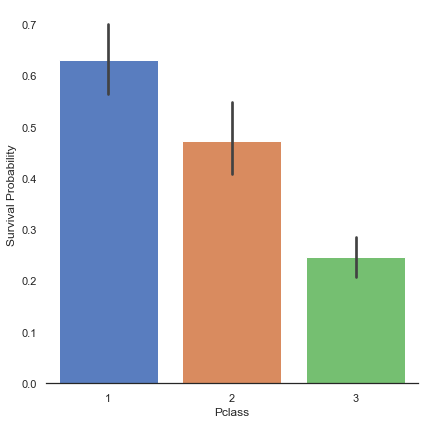

In [48]:
g = sns.factorplot(x = "Pclass", y = "Survived", data = train_df, kind = "bar", size = 6, palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Survival Probability")

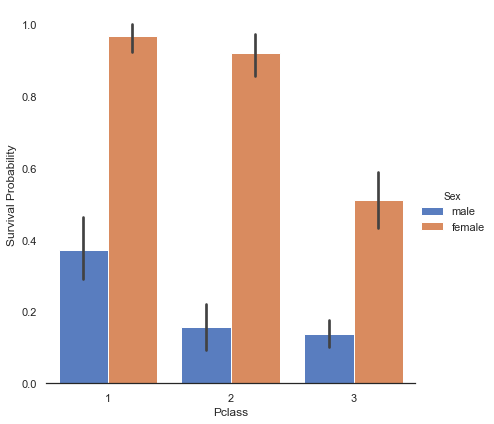

In [50]:
g = sns.factorplot(x = "Pclass", y = "Survived", hue = "Sex", data = train_df,
                  size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Survival Probability")

###### Embarked

In [51]:
df["Embarked"].isnull().sum()

2

In [52]:
df["Embarked"] = df["Embarked"].fillna("S")

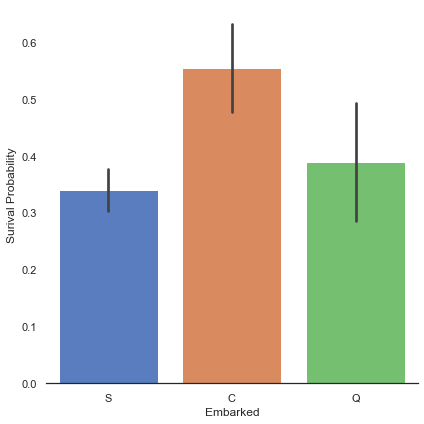

In [55]:
g = sns.factorplot(x = "Embarked", y = "Survived", data = train_df, size = 6, kind = "bar", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Surival Probability")

My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

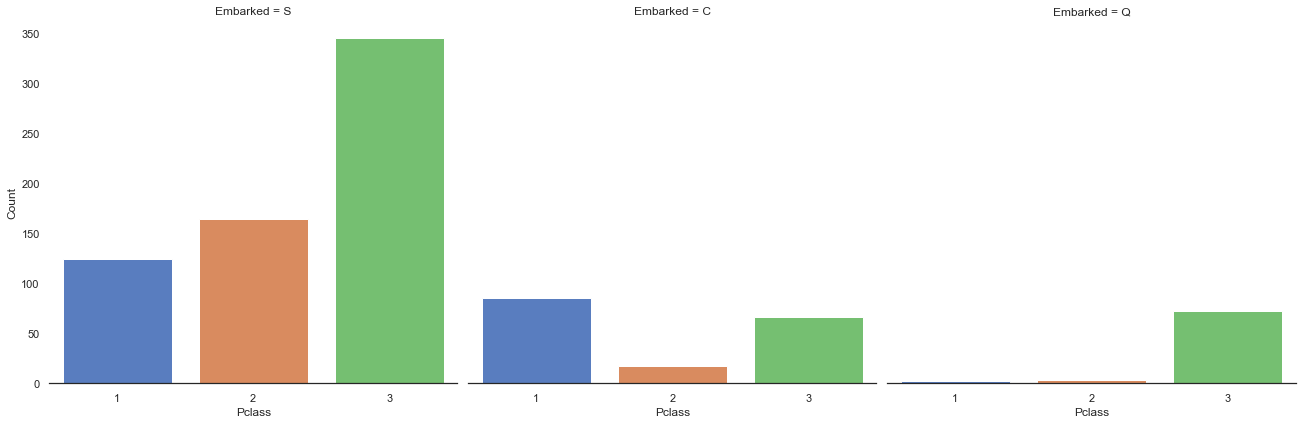

In [56]:
g = sns.factorplot("Pclass", col = "Embarked", data = train_df, size = 6, kind = "count", palette = "muted")
g.despine(left = True)
g = g.set_ylabels("Count")

### Filling missing Values

###### Age

null 값인 Age를 채우기 위해 Age와 상관관계가 있는 데이터를 찾는다. 이를 바탕으로 Age를 유추하여 채워넣는다.

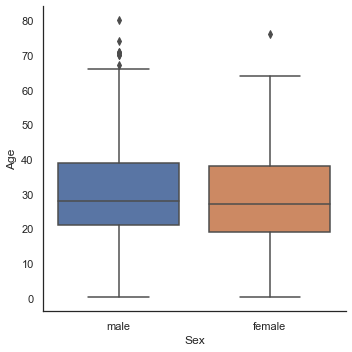

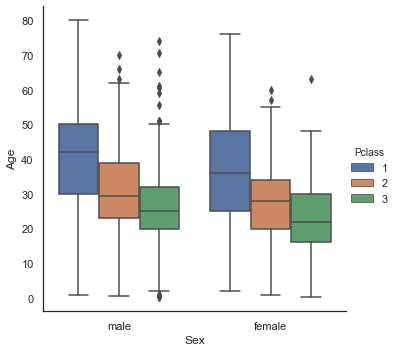

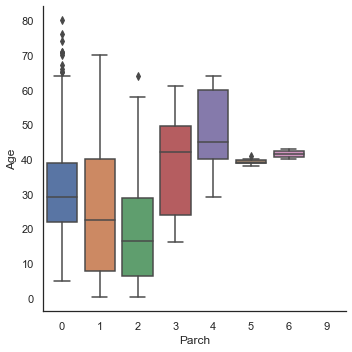

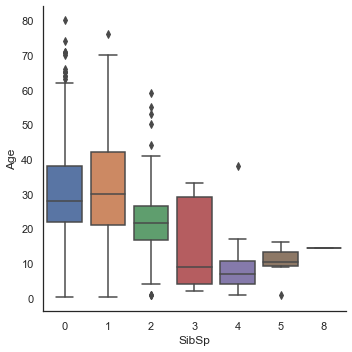

In [57]:
g = sns.factorplot(x = "Sex", y = "Age", data = df, kind = "box")
g = sns.factorplot(x = "Sex", y = "Age", hue = "Pclass", data = df, kind = "box")
g = sns.factorplot(x = "Parch", y = "Age", data = df, kind = "box")
g = sns.factorplot(x = "SibSp", y = "Age", data = df, kind = "box")

In [58]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

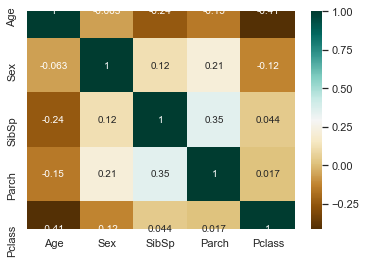

In [60]:
g = sns.heatmap(df[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap = "BrBG", annot = True)

In [61]:
index_NaN_age = list(df["Age"][df["Age"].isnull()].index)

for i in index_NaN_age:
    age_med = df["Age"].median()
    age_pred = df["Age"][((df["SibSp"] == df.iloc[i]["SibSp"]) & (df["Parch"] == df.iloc[i]["Parch"]) & (df["Pclass"] == df.iloc[i]["Pclass"]))].median()
    
    if not np.isnan(age_pred):
        df["Age"].iloc[i] = age_pred
    else:
        df["Age"].iloc[i] = age_med

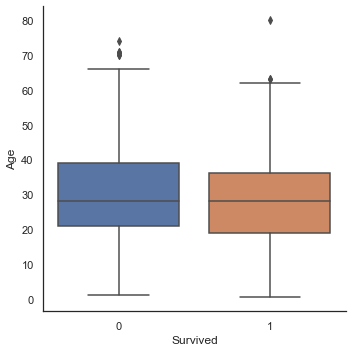

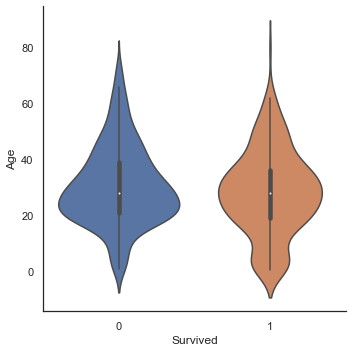

In [62]:
g = sns.factorplot(x = "Survived", y = "Age", data = train_df, kind = "box")
g = sns.factorplot(x = "Survived", y = "Age", data = train_df, kind = "violin")

# Feature Engineering

###### Name / Title

In [64]:
display(df["Name"].head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [67]:
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
display(df["Title"].head())

print(df["Title"].unique())

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


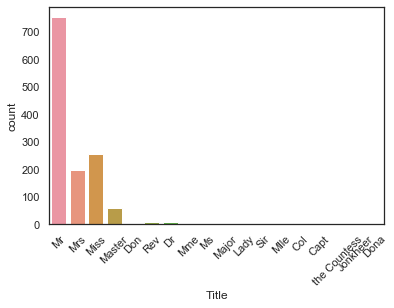

In [68]:
g = sns.countplot(x = "Title", data = df)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [69]:
df["Title"] = df["Title"].replace(["Lady", "the Countess", "Countess", "Capt", "Col", "Don",
                                  "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
df["Title"] = df["Title"].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
df["Title"] = df["Title"].astype(int)

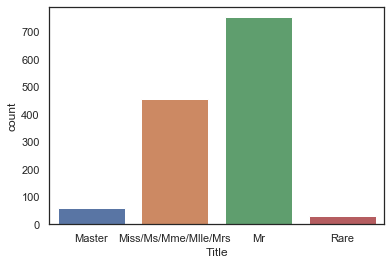

In [72]:
g = sns.countplot(df["Title"])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

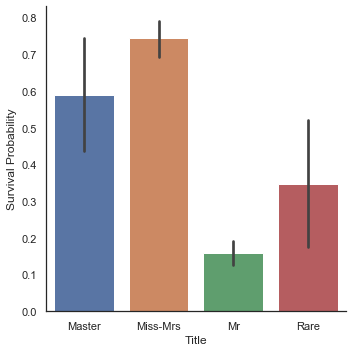

In [73]:
g = sns.factorplot(x = "Title", y = "Survived", data = df, kind = "bar")
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("Survival Probability")

In [74]:
df.drop(labels = ["Name"], axis = 1, inplace = True)

###### Family size

In [75]:
df["Family Size"] = df["SibSp"] + df["Parch"] + 1

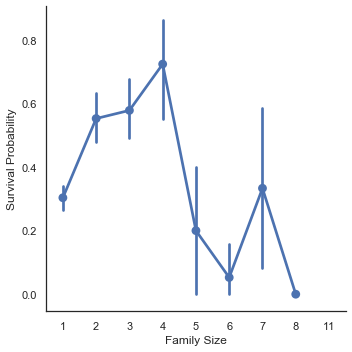

In [76]:
g = sns.factorplot(x = "Family Size", y = "Survived", data = df)
g = g.set_ylabels("Survival Probability")

In [77]:
df["Single"] = df["Family Size"].map(lambda s: 1 if s == 1 else 0)
df["SmallF"] = df["Family Size"].map(lambda s: 1 if s == 2 else 0)
df["MedF"] = df["Family Size"].map(lambda s: 1 if 3 <= s <= 4 else 0)
df["LargeF"] = df["Family Size"].map(lambda s: 1 if s>= 5 else 0)

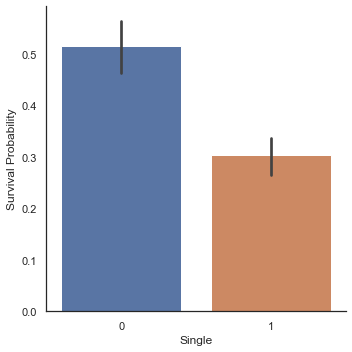

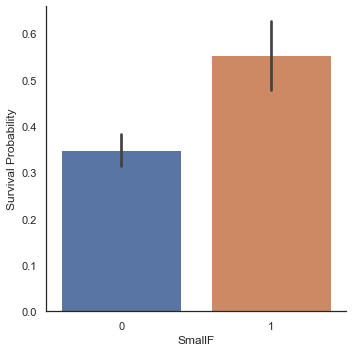

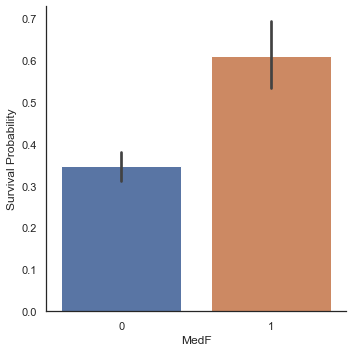

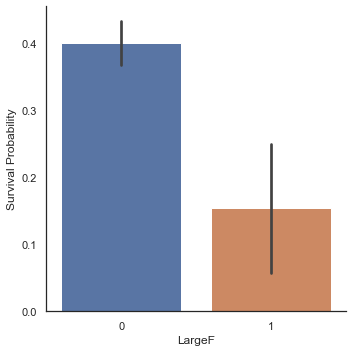

In [78]:
g = sns.factorplot(x = "Single", y = "Survived", data = df, kind = "bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = "SmallF", y = "Survived", data = df, kind = "bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = "MedF", y = "Survived", data = df, kind = "bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = "LargeF", y = "Survived", data = df, kind = "bar")
g = g.set_ylabels("Survival Probability")

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [79]:
df = pd.get_dummies(df, columns = ["Title"])
df = pd.get_dummies(df, columns = ["Embarked"], prefix = "Em")

###### Cabin

In [86]:
display(df["Cabin"].head())

print(df["Cabin"].describe())
print(df["Cabin"].isnull().sum())

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object
1007


In [87]:
df["Cabin"][df["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [91]:
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" for i in df["Cabin"]])

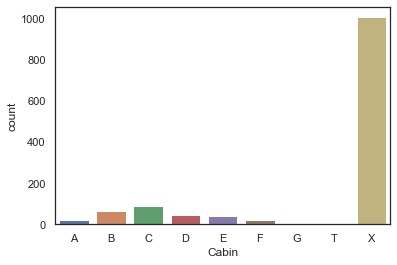

In [93]:
g = sns.countplot(df["Cabin"], order = ["A", "B", "C", "D", "E", "F", "G", "T", "X"])

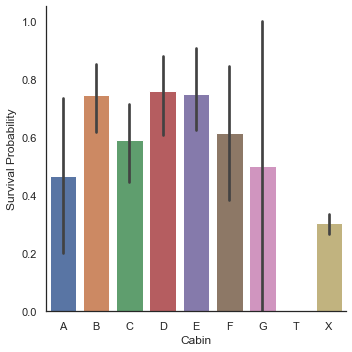

In [95]:
g = sns.factorplot(y = "Survived", x = "Cabin", data = df, kind = "bar",
                  order = ["A", "B", "C", "D", "E", "F", "G", "T", "X"])
g = g.set_ylabels("Survival Probability")

In [96]:
df = pd.get_dummies(df, columns = ["Cabin"], prefix = "Cabin")

##### Ticket

In [98]:
df[["Ticket"]].head()

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450


In [101]:
Ticket = []

for i in list(df.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(" ")[0])
    else:
        Ticket.append("X")

In [106]:
df["Ticket"] = Ticket

display(df["Ticket"].head())

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [107]:
df = pd.get_dummies(df, columns = ["Ticket"], prefix = "T")

In [111]:
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix = "Pc")

In [113]:
# df.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [115]:
display(df.head())
print(df.columns)

,Age,Fare,Parch,Sex,SibSp,Survived,Family Size,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'Family Size',
       'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1', 'Title_2',
       'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'T_A',
       'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C', 'T_CA', 'T_CASOTON',
       'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC', 'T_PP', 'T_PPP',
       'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW', 'T_SCPARIS',
       'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2', 'T_SOTONOQ',
       'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP',
       'T_X', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype='object')


# Modeling

In [124]:
train_df = df[:train_len]
test_df = df[train_len:]

test_df.drop(labels = ["Survived"], axis = 1, inplace = True)

In [125]:
train_df["Survived"] = train_df["Survived"].astype(int)

y_train = train_df["Survived"]
X_train = train_df.drop(labels = ["Survived"], axis = 1)

In [144]:
X_test = test_df

In [116]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

kfold = StratifiedKFold(n_splits = 10)

In [127]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state),
                                      random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = [] # cv 는 cross validation을 의미
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = "accuracy", cv = kfold))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValErrors": cv_std,
                       "Algorithm": ["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting", 
                                     "MultipleLayerPerceptron", "KNeighbors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

Text(0.5, 1.0, 'Cross validation scores')

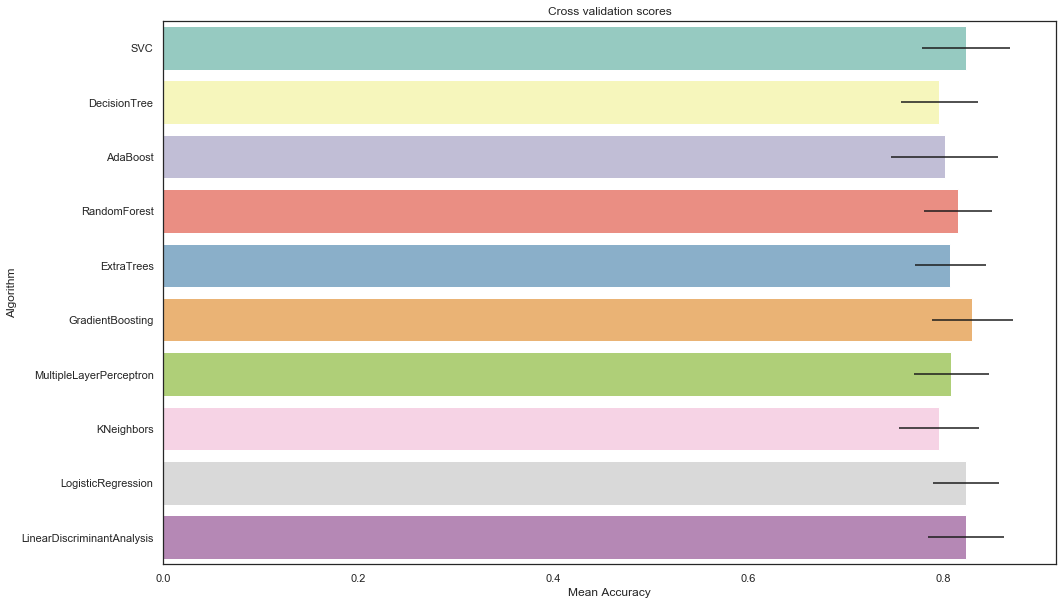

In [128]:
plt.figure(figsize = (16, 10))

sns.barplot("CrossValMeans", "Algorithm", data = cv_res,
           palette = "Set3", orient = "h", **{"xerr": cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [129]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"],
                 "base_estimator__splitter": ["best", "random"],
                 "algorithm": ["SAMME", "SAMME.R"], "n_estimators": [1, 2],
                 "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold,
                       scoring = "accuracy", verbose = 1)

gsadaDTC.fit(X_train, y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1120 out of 1120 | elapsed:   20.7s finished


In [130]:
gsadaDTC.best_score_

0.8240635641316686

In [131]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None], "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10], "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False], "n_estimators": [100, 300], "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = "accuracy", verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.8min finished


In [132]:
gsExtC.best_score_

0.8308740068104427

In [133]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None], "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10], "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False], "n_estimators": [100, 300], "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold,
                    scoring = "accuracy", verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.4min finished


In [134]:
gsRFC.best_score_

0.8331441543700341

In [135]:
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss": ["deviance"], "n_estimators": [100, 200, 300],
                "learning_rate": [0.1, 0.05, 0.01], "max_depth": [4, 8],
                "min_samples_leaf": [100, 150], "max_features": [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold,
                    scoring = "accuracy", verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.1min finished


In [136]:
gsGBC.best_score_

0.8342792281498297

In [137]:
SVMC = SVC(probability = True)

svc_param_grid = {"kernel": ["rbf"], "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold,
                     scoring = "accuracy", verbose = 1)

gsSVMC.fit(X_train, y_train)

SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  1.9min finished


In [138]:
gsSVMC.best_score_

0.8331441543700341

In [139]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure(figsize = (10, 6))
    
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, "o-", color = "r", label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, "o-", color = "g", label = "Cross Validation score")
    
    plt.legend(loc = "best")
    
    return plt

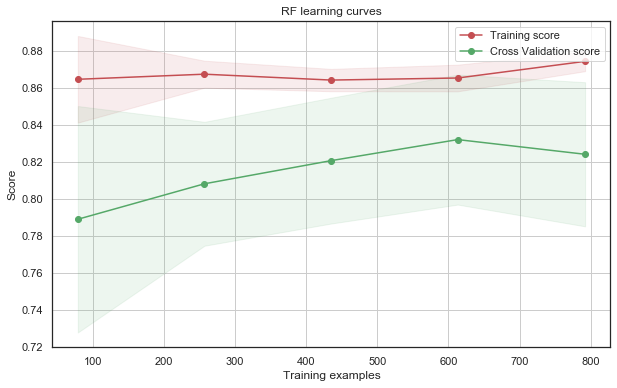

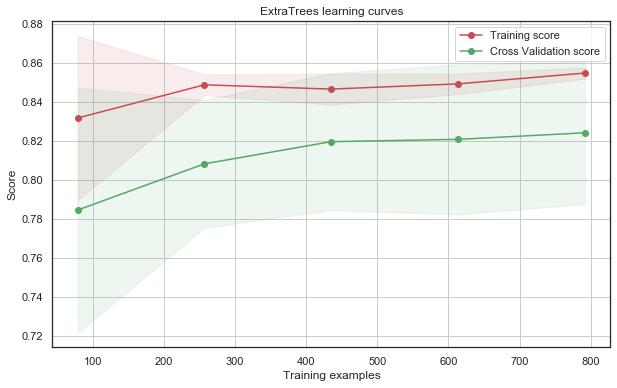

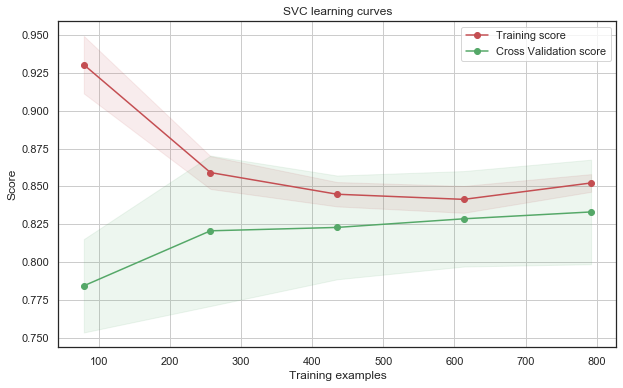

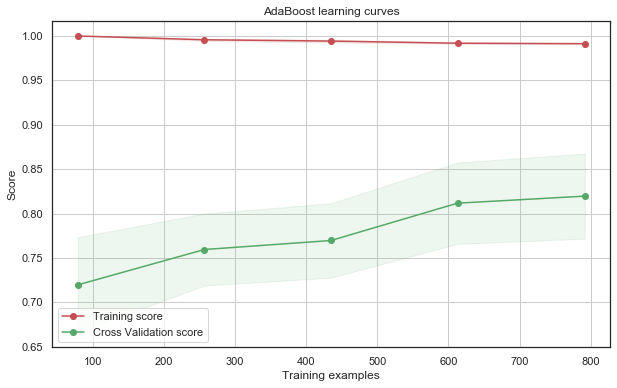

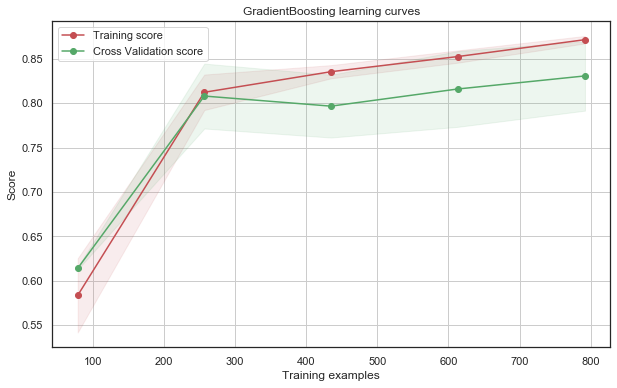

In [140]:
g = plot_learning_curve(gsRFC.best_estimator_, "RF learning curves", X_train, y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train, y_train, cv=kfold)

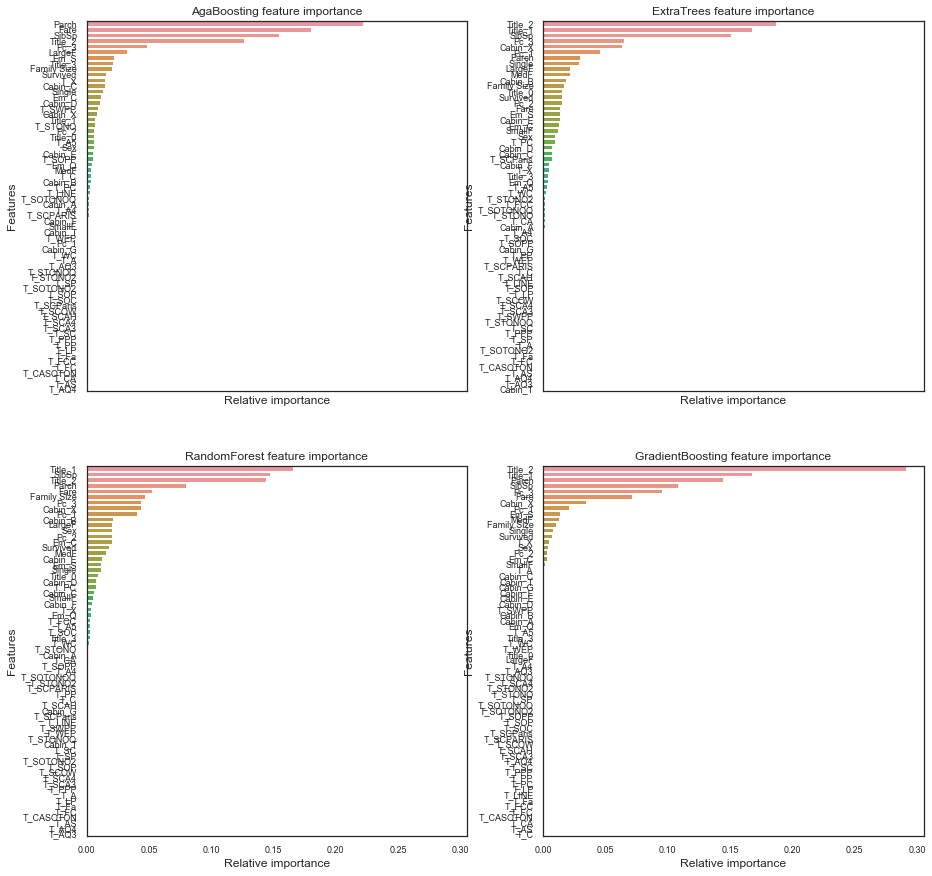

In [141]:
nrows = ncols = 2

fig, axes = plt.subplots(nrows = nrows , ncols = ncols, sharex = "all", figsize = (15, 15))

names_classifiers = [("AgaBoosting", ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1]
        
        g = sns.barplot(x = classifier.feature_importances_[indices],
                       y = train_df.columns[1:][indices], orient = "h", ax = axes[row][col])
        g.set_xlabel("Relative importance", fontsize = 12)
        g.set_ylabel("Features", fontsize = 12)
        g.tick_params(labelsize = 9)
        g.set_title(name + " feature importance")
        
        nclassifier += 1

In [146]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name = "RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name = "ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name = "SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name = "Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name = "GBC")

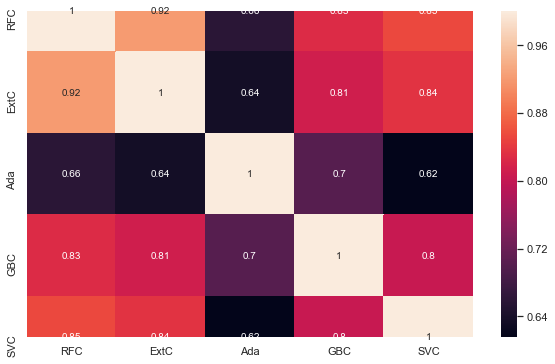

In [147]:
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC,
                             test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis = 1)

plt.figure(figsize = (10, 6))

sns.heatmap(ensemble_results.corr(), annot = True)

plt.show()

In [148]:
votingC = VotingClassifier(estimators = [("rfc", RFC_best), ("extc", ExtC_best),
                                        ("svc", SVMC_best), ("adac", ada_best), ("gbc", GBC_best)],
                          voting = "soft") # hard voting 과 soft voting 의 차이 알기

votingC = votingC.fit(X_train, y_train)

In [149]:
test_Survived = pd.Series(votingC.predict(X_test), name = "Survived")

results = pd.concat([test_id, test_Survived], axis = 1)

In [150]:
results.to_csv("ensemble_python_voting_.csv", index = False)